# Including proteins from TrEMBL with experimental evidence

In the notebook "swissprot_keywords_go_comparison", we saw that adding GO terms from the GO website to the Swissprot dataset does not provide additional samples. 

The idea for this notebook is the following:

- Filter unreviewed proteins from Uniprot by evidence for protein existence, and only keep those where the existence has been proven at protein level
- Combine this larger dataset with manually curated GO terms

This could give us a larger dataset than curated swissprot, and the data is still based on experimental evidence.

We will also try:

- Include GO-IEA terms
- Compare to keywords

Clarification:

Here, we refer to the Union of Swissprot and TrEMBL as "Uniprot". The set of all GO terms is refered to as "GO-IEA" (meaning *including* IEA). GO-NOIEA is a subset of GO-IEA, where the IEA terms have been removed.

### Data download

API Link:

Only existence 1 and no fragments, to save time:

https://rest.uniprot.org/uniprotkb/search?fields=accession%2Creviewed%2Cid%2Cgo_id%2Corganism_id%2Ckeywordid&format=tsv&query=%28%28existence%3A1%29%20AND%20%28fragment%3Afalse%29%29&size=500

Downloading custom Uniprot dataset using pagination:

The dataset has already been filtered for "protein evidence at protein sequence level", and only non-fragmented sequences are kept in the dataset.

In [2]:
# from subpred.uniprot_downloader import download_dataset

# download_dataset(
#     "https://rest.uniprot.org/uniprotkb/search?fields=accession%2Creviewed%2Cid%2Cgo_id%2Corganism_id%2Ckeywordid%2Csequence&format=tsv&query=%28%28existence%3A1%29%20AND%20%28fragment%3Afalse%29%29&size=500",
#     "/home/ad/uniprot_2022_04/uniprot_evidence_go_kw.tsv",
# )

Reading data:

In [3]:
import pandas as pd

df_uniprot = pd.read_table(
    "/home/ad/uniprot_2022_04/uniprot_evidence_go_kw.tsv", index_col=0
)
df_uniprot.head()

,Reviewed,Entry Name,Gene Ontology IDs,Organism (ID),Keyword ID,Sequence
Entry,,,,,,
A0A0C5B5G6,reviewed,MOTSC_HUMAN,GO:0001649; GO:0003677; GO:0005615; GO:0005634...,9606,KW-0238; KW-0496; KW-0539; KW-0892; KW-1185; K...,MRWQEMGYIFYPRKLR
A0A1B0GTW7,reviewed,CIROP_HUMAN,GO:0004222; GO:0005737; GO:0006508; GO:0007155...,9606,KW-0025; KW-0225; KW-0325; KW-1056; KW-0378; K...,MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...
A0JNW5,reviewed,UH1BL_HUMAN,GO:0005769; GO:0005829; GO:0042803; GO:0062069,9606,KW-0025; KW-0175; KW-0963; KW-0967; KW-0597; K...,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...
A0JP26,reviewed,POTB3_HUMAN,NaN,9606,KW-0025; KW-0040; KW-0175; KW-1185; KW-0677,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...
A0PK11,reviewed,CLRN2_HUMAN,GO:0007605; GO:0016021; GO:0032421; GO:0060088...,9606,KW-1003; KW-0966; KW-0209; KW-0225; KW-0325; K...,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...


Removing proteins with invalid sequences:

In [4]:
import re

df_uniprot = df_uniprot[
    df_uniprot.Sequence.str.match(re.compile("[ACDEFGHIKLMNPQRSTVWY]+"))
]

Parsing the GO terms:

In [5]:
df_uniprot_go = df_uniprot["Gene Ontology IDs"].rename("go_id")
df_uniprot_go = df_uniprot_go[~df_uniprot_go.isnull()]
df_uniprot_go = df_uniprot_go.str.split(";").explode().str.strip()
df_uniprot_go = df_uniprot_go.reset_index(drop=False)
df_uniprot_go.head()

,Entry,go_id
0,A0A0C5B5G6,GO:0001649
1,A0A0C5B5G6,GO:0003677
2,A0A0C5B5G6,GO:0005615
3,A0A0C5B5G6,GO:0005634
4,A0A0C5B5G6,GO:0005739


Subset of Swissprot GO terms:

In [6]:
swissprot_proteins = set(df_uniprot[df_uniprot.Reviewed == "reviewed"].index.to_list())
df_swissprot_go = df_uniprot_go[
    df_uniprot_go.Entry.isin(swissprot_proteins)
].reset_index(drop=True)

Loading the ontology:

In [7]:
from subpred.go_utils import GeneOntology

go = GeneOntology("../data/raw/ontologies/go.owl")

GO term sets:

In [8]:
transmembrane_transport_descendants = go.get_descendants(
    go.get_identifier("transmembrane transporter activity")
)
amino_acid_descendants = go.get_descendants(
    go.get_identifier("amino acid transmembrane transporter activity")
)
carbohydrate_descendants = go.get_descendants(
    go.get_identifier("carbohydrate transmembrane transporter activity")
)
sugar_descendants = go.get_descendants(
    go.get_identifier("sugar transmembrane transporter activity")
)
ion_descendants = go.get_descendants(
    go.get_identifier("ion transmembrane transporter activity")
)

### GO dataset from GO website (No-IEA)

In [23]:
df_go_noiea = pd.read_table(
    "/home/ad/gene_ontology/goa_uniprot_all_noiea.gaf.gz",
    header=None,
    names=[
        "db",
        "db_object_id",
        "db_object_symbol",
        "qualifier",
        "go_id",
        "db_reference",
        "evidence_code",
        "with_or_from",
        "aspect",
        "db_object_name",
        "db_object_synonym",
        "db_object_type",
        "taxon",
        "date",
        "assigned_by",
        "annotation_extension",
        "gene_product_form_id",
    ],
)
df_go_noiea.head()

,db,db_object_id,db_object_symbol,qualifier,go_id,db_reference,evidence_code,with_or_from,aspect,db_object_name,db_object_synonym,db_object_type,taxon,date,assigned_by,annotation_extension,gene_product_form_id
0,UniProtKB,Q5R8N4,VPS35L,located_in,GO:0005768,GO_REF:0000024,ISS,UniProtKB:Q7Z3J2,C,VPS35 endosomal protein-sorting factor-like,VPS35L,protein,taxon:9601,20190110,UniProt,NaN,NaN
1,UniProtKB,Q5R8N4,VPS35L,involved_in,GO:0032456,GO_REF:0000024,ISS,UniProtKB:Q7Z3J2,P,VPS35 endosomal protein-sorting factor-like,VPS35L,protein,taxon:9601,20190114,UniProt,NaN,NaN
2,UniProtKB,Q87UX2,blc,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Outer membrane lipoprotein Blc,blc|PSPTO_5170,protein,taxon:223283,20061207,JCVI,NaN,NaN
3,UniProtKB,Q87UX2,blc,involved_in,GO:0008150,GO_REF:0000015,ND,NaN,P,Outer membrane lipoprotein Blc,blc|PSPTO_5170,protein,taxon:223283,20061207,JCVI,NaN,NaN
4,UniProtKB,C8VDI1,AN11006,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Uncharacterized protein AN11006,AN11006,protein,taxon:227321,20200401,AspGD,NaN,NaN


Filtering for "enables" qualifier (protein is directly responsible for the function), and UniProt entries (as opposed to other gene products like mRNA)

In [24]:
df_go_noiea = df_go_noiea[
    (df_go_noiea.db == "UniProtKB")
    & (df_go_noiea.qualifier == "enables")
    & (df_go_noiea.aspect == "F")
]
df_go_noiea = df_go_noiea[["db_object_id", "go_id"]]
df_go_noiea = df_go_noiea[df_go_noiea.db_object_id.isin(df_uniprot.index)]
df_go_noiea = df_go_noiea.reset_index(drop=True).rename(columns={"db_object_id": "Uniprot"})
df_go_noiea

,Uniprot,go_id
0,Q93AM0,GO:0008047
1,Q9A9T8,GO:0005515
2,P04014,GO:0003678
3,P04014,GO:0003677
4,P04014,GO:0003677
...,...,...
24299,P00180,GO:0005515
24300,A1C3L9,GO:0016757
24301,A1C3L9,GO:0016757
24302,A1C3L9,GO:0005515


### Go dataset (IEA)

Preprocessed file, only contains "enables" qualifier and "molecular function" terms

In [11]:
df_go_iea = pd.read_table(
    "/home/ad/gene_ontology/goa_sp_iea_mf_enables.tsv",
    header=None,
    names=["Uniprot", "go_id", "evidence_code"],
)

In [12]:
df_go_iea = df_go_iea[df_go_iea.Uniprot.isin(df_uniprot.index)]

Is filtering IEA terms from the larger file the same as reading the no-iea file?

The resulting Venn diagrams were the same, but do they contain exactly the same annotations?

In [34]:
df_go_noiea2 = df_go_iea[df_go_iea.evidence_code != "IEA"].rename(columns={"db_object_id": "Uniprot"}).drop("evidence_code",axis=1).reset_index(drop=True)
(df_go_noiea.sort_values(["Uniprot", "go_id"]).reset_index(drop=True) == df_go_noiea2.sort_values(["Uniprot", "go_id"]).reset_index(drop=True)).all()

Uniprot    True
go_id      True
dtype: bool

Yes, they are the same. We can just read the smaller file if we don't need IEA annotations

## Venn diagrams

In [35]:
from venn import venn
import matplotlib.pyplot as plt


def venn_plot_go(go_set: set):
    tmt_swissprot = set(
        df_swissprot_go[df_swissprot_go.go_id.isin(go_set)].Entry.to_list()
    )
    tmt_uniprot = set(df_uniprot_go[df_uniprot_go.go_id.isin(go_set)].Entry.to_list())
    tmt_go_noiea = set(
        df_go_noiea[df_go_noiea.go_id.isin(go_set)].Uniprot.to_list()
    )
    tmt_go_iea = set(df_go_iea[df_go_iea.go_id.isin(go_set)].Uniprot.to_list())
    venn(
        {
            "go-swissprot": tmt_swissprot,
            "go-uniprot": tmt_uniprot,
            "go-noiea": tmt_go_noiea,
            "go-iea": tmt_go_iea,
        }
    )


### Transmembrane transporters

Adding TrEMBL transporters more than doubles the number of samples. There is also a considerable overlap with GO-IEA annotations for both Uniprot datasets. We will explore later if these are the keywords (keywords are included in GO as IEA terms).

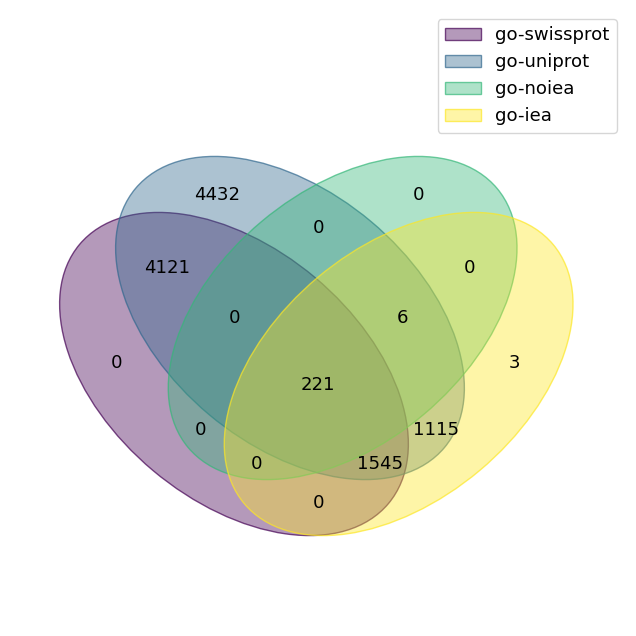

In [36]:
venn_plot_go(transmembrane_transport_descendants)

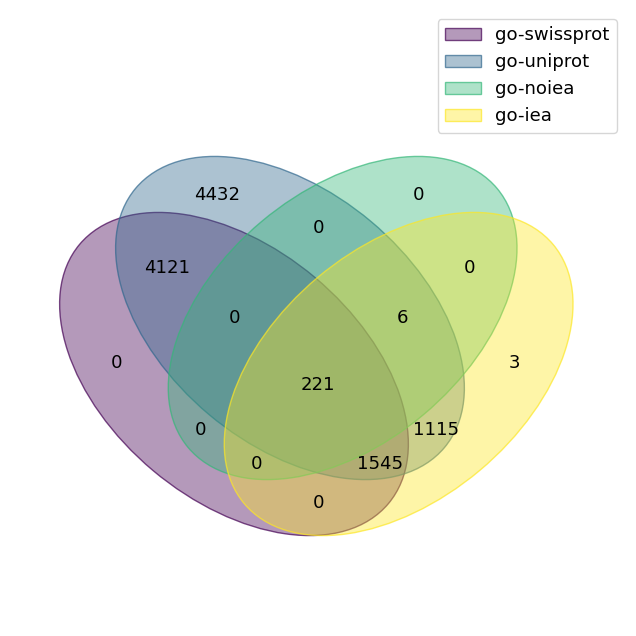

In [37]:
venn_plot_go(transmembrane_transport_descendants)

### Sugar

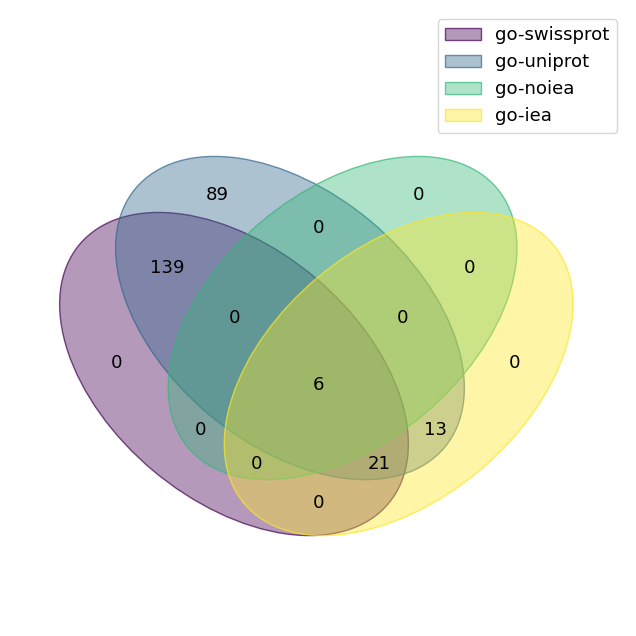

In [38]:
venn_plot_go(sugar_descendants)

### Carbohydrate

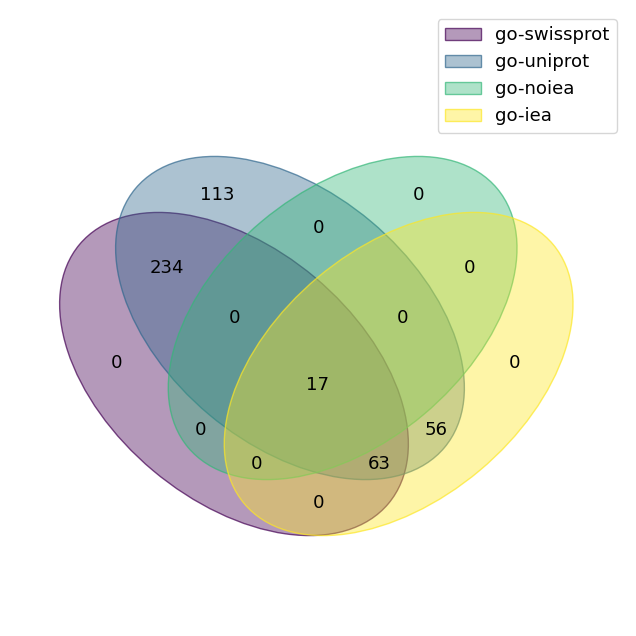

In [39]:
venn_plot_go(carbohydrate_descendants)


### Amino acid

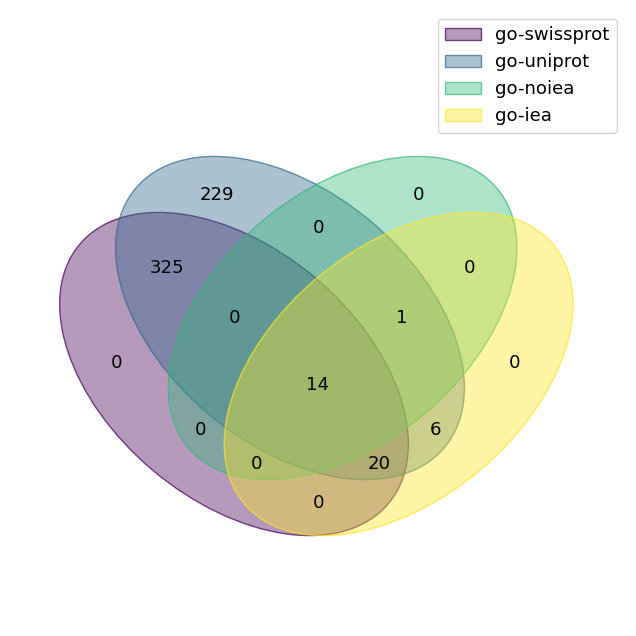

In [40]:
venn_plot_go(amino_acid_descendants)


## Keywords

Roughly equivalent keywords:

- Transport (KW-0813)
- Transmembrane (KW-0812)
- Sugar transport: KW-0762
- Amino-acid transport: 
- Ion transport: KW-0406

In [41]:
keywords = {
    "Transmembrane" : "KW-0812",
    "Transport": "KW-0813",
    "Sugar transport": "KW-0762",
    "Amino-acid transport": "KW-0029",
    "Ion transport": "KW-0406"
}

In [42]:
df_uniprot_kw = df_uniprot["Keyword ID"].rename("kw_ids")
df_uniprot_kw = df_uniprot_kw[~df_uniprot_kw.isnull()]
df_uniprot_kw = df_uniprot_kw.str.split(";").explode().str.strip()
df_uniprot_kw = df_uniprot_kw.reset_index(drop=False)
df_uniprot_kw = df_uniprot_kw.merge(
    df_uniprot.Reviewed, how="inner", left_on="Entry", right_index=True
)
df_uniprot_kw.head()


,Entry,kw_ids,Reviewed
0,A0A0C5B5G6,KW-0238,reviewed
1,A0A0C5B5G6,KW-0496,reviewed
2,A0A0C5B5G6,KW-0539,reviewed
3,A0A0C5B5G6,KW-0892,reviewed
4,A0A0C5B5G6,KW-1185,reviewed


In [43]:
transmembrane_proteins = df_uniprot_kw[df_uniprot_kw.kw_ids == keywords["Transmembrane"]].Entry.unique()
df_uniprot_kw_transmembrane = df_uniprot_kw[
    df_uniprot_kw.Entry.isin(transmembrane_proteins)
].reset_index(drop=True)

df_uniprot_kw_transmembrane.head()


,Entry,kw_ids,Reviewed
0,A0A1B0GTW7,KW-0025,reviewed
1,A0A1B0GTW7,KW-0225,reviewed
2,A0A1B0GTW7,KW-0325,reviewed
3,A0A1B0GTW7,KW-1056,reviewed
4,A0A1B0GTW7,KW-0378,reviewed


### How do the Keywords protein sets compare to the Uniprot GO sets?

We already figured out that the official GO datasets are a subset of the Uniprot GO sets. What is the overlap between Uniprot-GO and Uniprot-Keyword?

#### Creating protein sets for keywords

In [44]:
def venn_plot_kw(go_set: set, keyword:str):
    go_swissprot = set(
        df_swissprot_go[df_swissprot_go.go_id.isin(go_set)].Entry.to_list()
    )
    go_uniprot = set(df_uniprot_go[df_uniprot_go.go_id.isin(go_set)].Entry.to_list())
    kw_uniprot = set(
        df_uniprot_kw_transmembrane[
            (df_uniprot_kw_transmembrane.kw_ids == keyword)
        ].Entry.unique()
    )
    kw_swissprot = set(
        df_uniprot_kw_transmembrane[
            (df_uniprot_kw_transmembrane.kw_ids == keyword)
            & (df_uniprot_kw_transmembrane.Reviewed == "reviewed")
        ].Entry.unique()
    )
    venn({"go-swissprot": go_swissprot, "go-uniprot": go_uniprot, "kw-swissprot": kw_swissprot, "kw-uniprot": kw_uniprot})


#### Transmembrane transport

The keyword annotations add 1638 proteins when only looking at manual annotations, and 4704 when also including electronic Keyowrd annotations. These electronic annotations have a significant overlap of 3099 proteins with the GO terms from TrEMBL. A similar pattern occurs for the substrates below.

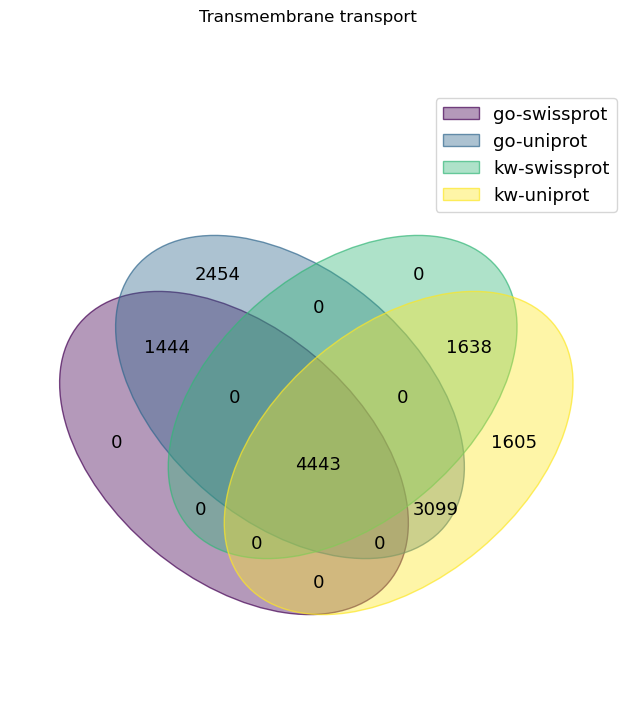

In [45]:
venn_plot_kw(transmembrane_transport_descendants, keywords["Transport"])
plt.suptitle("Transmembrane transport")
plt.show()

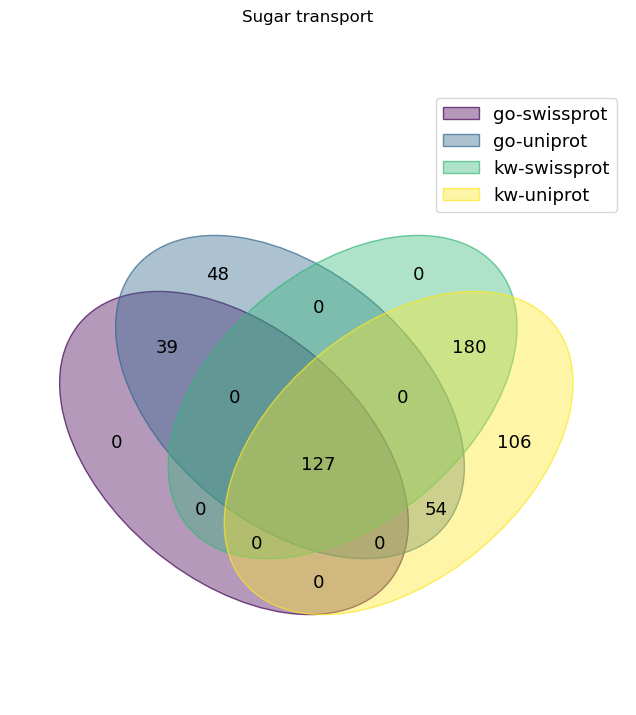

In [71]:
venn_plot_kw(sugar_descendants, keywords["Sugar transport"])
plt.suptitle("Sugar transport")
plt.show()

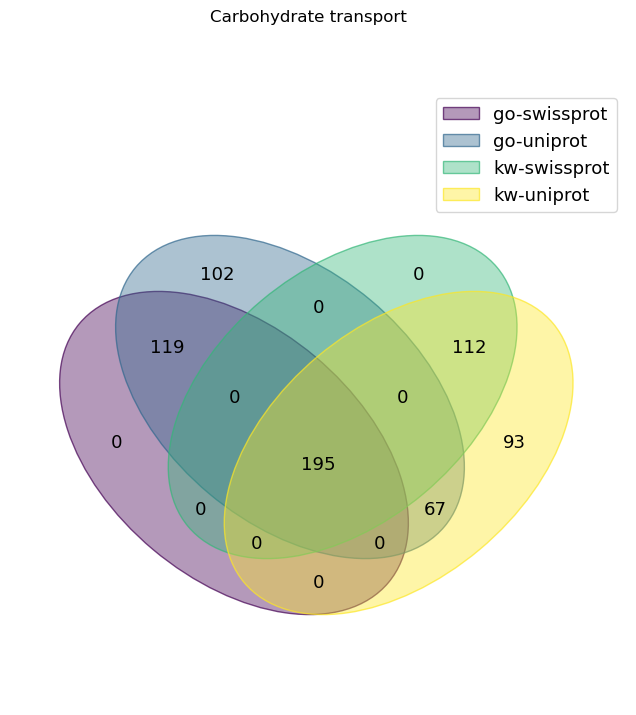

In [72]:
venn_plot_kw(carbohydrate_descendants, keywords["Sugar transport"])
plt.suptitle("Carbohydrate transport")
plt.show()

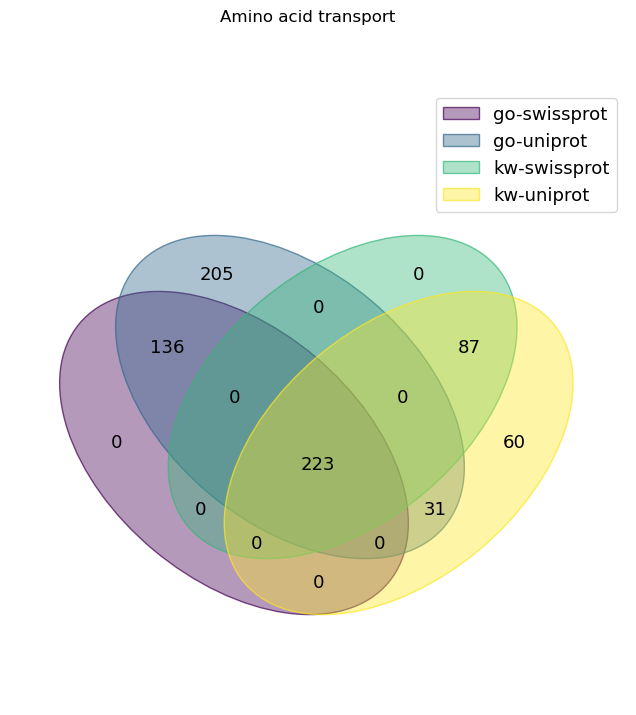

In [73]:
venn_plot_kw(amino_acid_descendants, keywords["Amino-acid transport"])
plt.suptitle("Amino acid transport")
plt.show()

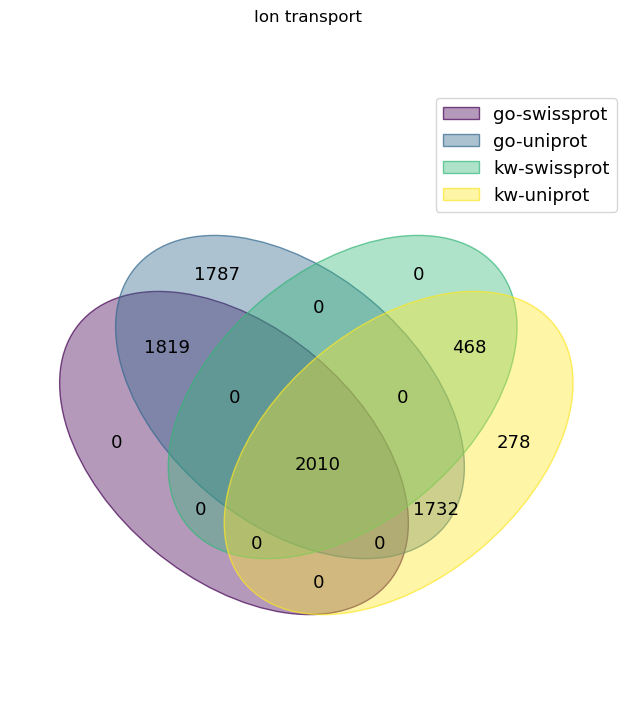

In [74]:
venn_plot_kw(ion_descendants, keywords["Ion transport"])
plt.suptitle("Ion transport")
plt.show()

### How many GO terms/Keywords in TrEMBL are mapped to IEA terms?

Do TrEMBL proteins only have IEA GO terms, or is there a considerable number of non-IEA transmembrane transporter GO annotations for TrEMBL proteins? 

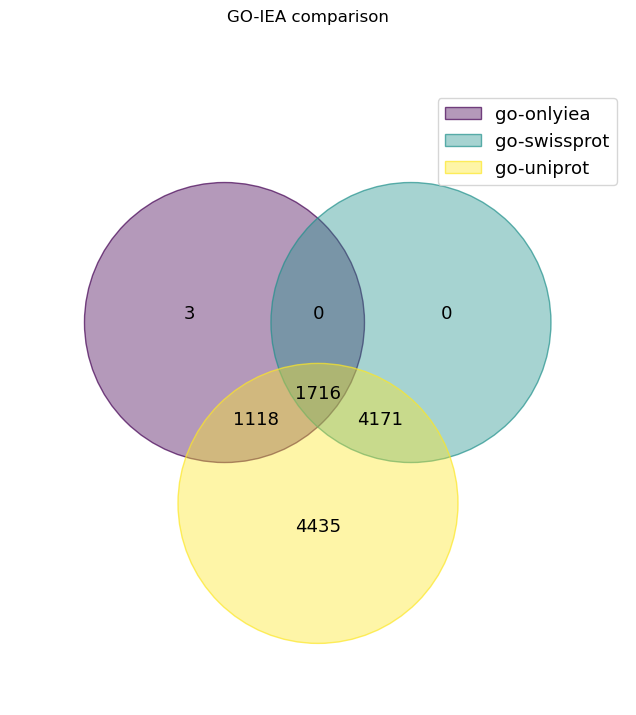

In [46]:
go_set = transmembrane_transport_descendants
keyword = keywords["Transport"]
df_go_iea_only = df_go_iea[df_go_iea.evidence_code == "IEA"]
tmt_go_only_iea = set(
    df_go_iea_only[df_go_iea_only.go_id.isin(go_set)].Uniprot.to_list()
)
go_swissprot = set(df_swissprot_go[df_swissprot_go.go_id.isin(go_set)].Entry.to_list())
go_uniprot = set(df_uniprot_go[df_uniprot_go.go_id.isin(go_set)].Entry.to_list())
venn(
    {
        "go-onlyiea": tmt_go_only_iea,
        "go-swissprot": go_swissprot,
        "go-uniprot": go_uniprot,
    }
)
plt.suptitle("GO-IEA comparison")
plt.show()


Virtually all GO IEA annotations are included in Uniprot. Of all the transmembrane transport GO anntations of Swissprot+TrEMBL proteins, 2834 are marked as IEA, 1716 of which are in Swissprot. Since Swissprot is manually curated, we can assume that these IEA terms were assigned to the Swissprot entry by a curator. 

This plot shows us that the majority of transmembrane transporter GO annotations in TrEMBL are non-IEA GO terms, and can therefore be used for out training dataset.

The latter is also true for keywords, although there is a larger number of annotations where only IEA terms exist. The lower overlap could be caused by the fact that combining the Transport and Transmembrane keywords is only a rough estimate of the more accurate "transmembrane transporters activity" GO term.

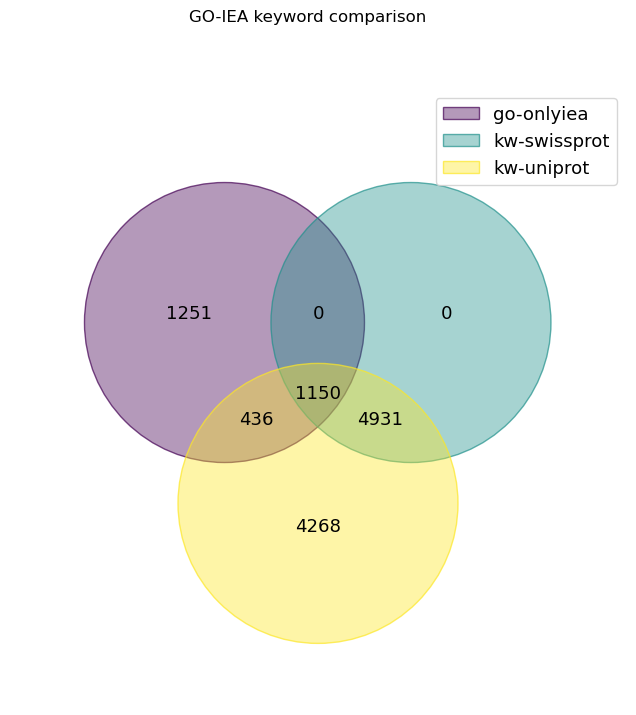

In [47]:
go_set = transmembrane_transport_descendants
keyword = keywords["Transport"]
df_go_iea_only = df_go_iea[df_go_iea.evidence_code == "IEA"]
tmt_go_only_iea = set(df_go_iea_only[df_go_iea_only.go_id.isin(go_set)].Uniprot.to_list())
kw_uniprot = set(
    df_uniprot_kw_transmembrane[
        (df_uniprot_kw_transmembrane.kw_ids == keyword)
    ].Entry.unique()
)
kw_swissprot = set(
    df_uniprot_kw_transmembrane[
        (df_uniprot_kw_transmembrane.kw_ids == keyword)
        & (df_uniprot_kw_transmembrane.Reviewed == "reviewed")
    ].Entry.unique()
)
venn(
    {
        "go-onlyiea": tmt_go_only_iea,
        "kw-swissprot": kw_swissprot,
        "kw-uniprot": kw_uniprot,
    }
)
plt.suptitle("GO-IEA keyword comparison")
plt.show()

## Summary

- Combining experimentally verified proteins from TrEMBL with experimentally verified annotations from GO can increase the sample size by up to 100%. 
- Using the GO datasets from the official website, as well as IEA terms, did not yield additional data.
- Including manually annotated Keywords from Swissprot adds 1638 additional transporters, compared to GO. 
- The vast majority of transmembrane transporter GO annotations in TrEMBL are not electronically inferred, making them suitable for our training dataset.

## Conclusion

If the goal is to increase the number of samples without relying on electronically inferred information, then the dataset would be made up of the following:
- TrEMBL & Swissprot proteins
    - Protein existence verified at protein level
    - If we need more samples, we could include evidence at transcript level.
- Annotations
    - Non-IEA GO terms, filtered by "enables" qualifier
        - "Enables" means that the protein is directly responsible for the molecular function
        - Uniprot can also contain less accurate qualifiers
    - Swissprot Keywords
        - Since TrEMBL keywords are electronically annotated.

Other ideas:
- Create a very accurate set from the overlap of verified GO terms and Keywords, for validation set.
- Create a union set including all information, use for validating ML models.

TODO link Uniprot GO annotations to official GO datasets, in order to get qualifiers back.